<a href="https://colab.research.google.com/github/quent1fvr/Infection_pulmonaire/blob/main/modele_CNN_GRU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **0 - Importation des données et librairies**



In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import tensorflow
import keras
from tensorflow.keras import models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.layers import TimeDistributed
from keras.layers import Conv2D, BatchNormalization,MaxPooling2D, GlobalMaxPool2D
from keras.layers import TimeDistributed, GRU, Dense, Dropout
from sklearn.metrics import classification_report, confusion_matrix




In [20]:
hf_normal= h5py.File("/content/drive/MyDrive/UV PROJET P6/Dataset_normal.hdf5", "r")
hf_malade= h5py.File("/content/drive/MyDrive/UV PROJET P6/Dataset_malade.hdf5", "r")

Data_normal = np.array(hf_normal["dataset_1"][:]) #dataset_name is same as hdf5 object name 
Data_malade = np.array(hf_malade["dataset_2"][:])

# **1 - Etude des données et création des labels**



In [21]:
Data_normal.shape , Data_malade.shape

((55720, 48, 48), (54600, 48, 48))

In [22]:
Data_normal = Data_normal.reshape(Data_normal.shape[0]//70,70,48,48) # work on 1576 samples of 70 scans of size 48*48
Data_malade = Data_malade.reshape(Data_malade.shape[0]//70,70,48,48) # work on 1576 samples of 70 scans of size 48*48
Data = np.concatenate((Data_normal,Data_malade))
Data.shape

(1576, 70, 48, 48)

Le jeu de données est composé de séquences de 70 images par scan, c'est pourquoi on atteibue un label pour chaque séquence :
- 0 : La personne est négative au COVID. 
- 1 : La personne est positive au COVID

In [23]:
Y_normal = np.zeros(Data_normal.shape[0],dtype = np.int8) # 70 images per scan
Y_malade = np.ones(Data_malade.shape[0],dtype = np.int8)
Y = np.concatenate((Y_normal,Y_malade))
Y.shape


(1576,)

# **2 - Création d'un modèle CNN + GRU**




In [8]:
def build_convnet(shape=(48, 48)):
    momentum = .9
    model = keras.Sequential()
    model.add(Conv2D(64, (3,3), input_shape=shape,
        padding='same', activation='relu'))
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    model.add(MaxPooling2D())
    
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    
    # flatten...
    model.add(GlobalMaxPool2D())
    return model

In [9]:
def action_model(shape=(70,48, 48), nbout=1):
    # Create our convnet with (112, 112, 3) input shape
    convnet = build_convnet(shape[1:])
    
    # then create our final model
    model = keras.Sequential()
    # add the convnet with (70,48,48,3) shape
    model.add(TimeDistributed(convnet, input_shape=(70,48, 48,1)))
    # add the GRU cell
    model.add(GRU(64))
    # and finally, we make a decision network
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(nbout, activation='sigmoid'))
    return model

In [10]:
# some global params
SIZE = (48, 48)
NBFRAME = 70
BS = 8
CHANNEL = 1

In [13]:
INSHAPE=(70,48,48,1)
print(INSHAPE)
model = action_model(INSHAPE, nbout=1)
optimizer = tensorflow.keras.optimizers.Adam(0.001)
model.compile(
    optimizer,
    'binary_crossentropy',
    metrics=['acc']
)

(70, 48, 48, 1)


On fixe la graine aléatoire afin que l'on puisse avoir des résultats similaires en relançant l'apprentissage : 

In [14]:
def fix_seed(seed):
    tensorflow.random.set_seed(seed)

SEED = 42
fix_seed(SEED)

On utilise les callbacks EarlyStop et ModelCheckpoint pour optimiser nos résultats : 

In [26]:
my_callbacks = [
    tensorflow.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 20,
                          verbose = 1,
                          restore_best_weights = True),
    tensorflow.keras.callbacks.ModelCheckpoint(filepath='/tmp/myModel.h5')
]



# **3 - Apprentissage et interprétation des résultats**


In [27]:
model.fit(Data,Y,epochs=50, validation_split=0.2, batch_size=BS, callbacks=my_callbacks)

Epoch 1/50
158/158 [==============================] - 41s 262ms/step - loss: 0.2877 - acc: 0.8873 - val_loss: 0.3709 - val_acc: 0.8133
Epoch 2/50
158/158 [==============================] - 42s 268ms/step - loss: 0.2958 - acc: 0.8810 - val_loss: 0.3655 - val_acc: 0.8766
Epoch 3/50
158/158 [==============================] - 42s 267ms/step - loss: 0.2431 - acc: 0.8937 - val_loss: 0.9472 - val_acc: 0.4747
Epoch 4/50
158/158 [==============================] - 42s 268ms/step - loss: 0.3266 - acc: 0.8698 - val_loss: 0.2003 - val_acc: 0.8481
Epoch 5/50
158/158 [==============================] - 42s 268ms/step - loss: 0.2511 - acc: 0.9103 - val_loss: 0.1471 - val_acc: 0.9177
Epoch 6/50
158/158 [==============================] - 42s 268ms/step - loss: 0.2421 - acc: 0.9040 - val_loss: 0.5277 - val_acc: 0.7342
Epoch 7/50
158/158 [==============================] - 42s 268ms/step - loss: 0.2153 - acc: 0.9167 - val_loss: 0.2628 - val_acc: 0.8766
Epoch 8/50
158/158 [==============================] - 4

[0.8873015642166138, 0.8809523582458496, 0.8936507701873779, 0.8698412775993347, 0.9103174805641174, 0.9039682745933533, 0.9166666865348816, 0.9190475940704346, 0.9301587343215942, 0.9373015761375427, 0.9269841313362122, 0.9253968000411987, 0.9365079402923584, 0.9293650984764099, 0.9277777671813965, 0.9420635104179382, 0.9285714030265808, 0.9190475940704346, 0.9269841313362122, 0.9309523701667786, 0.9301587343215942, 0.9253968000411987, 0.9333333373069763, 0.9388889074325562, 0.9452381134033203]
[0.8132911324501038, 0.8765822649002075, 0.474683552980423, 0.8481012582778931, 0.9177215099334717, 0.7341772317886353, 0.8765822649002075, 0.8670886158943176, 0.9018987417221069, 0.7848101258277893, 0.8417721390724182, 0.8860759735107422, 0.9335442781448364, 0.7120253443717957, 0.905063271522522, 0.8987341523170471, 0.8196202516555786, 0.8512658476829529, 0.905063271522522, 0.8765822649002075, 0.9082278609275818, 0.8734177350997925, 0.9145569801330566, 0.892405092716217, 0.9082278609275818]
[0

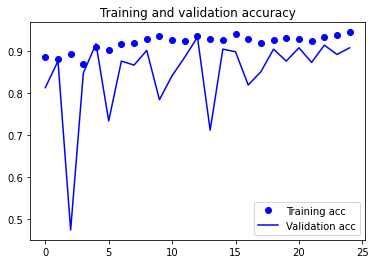

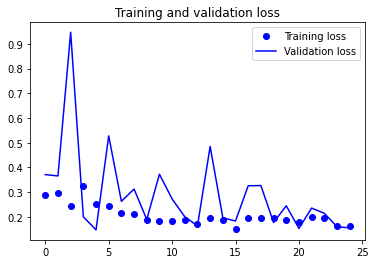

In [28]:
acc = model.history.history['acc']
val_acc = model.history.history['val_acc']
loss = model.history.history['loss']
val_loss = model.history.history['val_loss']

print(acc)
print(val_acc)

print(loss)
print(val_loss)

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# **4 - Test sur un jeu de données aléatoire**


In [29]:
Data_test = []
for i in range(15):
  aleatoire = np.random.randint(0,Data_normal.shape[0])
  Data_test.append(Data_normal[aleatoire][:])
for i in range(15):
  aleatoire = np.random.randint(0,Data_malade.shape[0])
  Data_test.append(Data_malade[aleatoire][:])
Data_test = np.array(Data_test)
Data_test.shape

(30, 70, 48, 48)

In [30]:
Y_test_normal= np.zeros(15)
Y_test_malade = np.ones(15)
Y_test = np.concatenate((Y_test_normal,Y_test_malade))

In [31]:
model.evaluate(Data_test,Y_test)

1/1 [==============================] - 4s 4s/step - loss: 0.2347 - acc: 0.8667


[0.23468488454818726, 0.8666666746139526]

In [32]:
preds = np.round(model.predict(Data_test),0)
cm = confusion_matrix(Y_test, preds)
print(cm)


[[13  2]
 [ 2 13]]


Les résultats obtenus avec ce modèle sont assez satisfaisants, on ne fait pas face à un problème d'overfitting à la vue des courbes et de la prédiction sur le jeu de test.